# Interpretable Machine Learning with LIME for Image Classification
By: Cristian Arteaga, [arteagac.github.io](https://arteagac.github.io)

![banner](https://arteagac.github.io/blog/lime_image/img/lime_banner.png)

In this post, we will study how LIME  (Local Interpretable Model-agnostic Explanations) ([Ribeiro et. al. 2016](https://arxiv.org/abs/1602.04938)) generates explanations for image classification tasks. The basic idea is to understand why a machine learning model (deep neural network) predicts that an instance (image) belongs to a certain class (labrador in this case). For an introductory guide about how LIME works, I recommend you to check my previous blog post [Interpretable Machine Learning with LIME](https://nbviewer.jupyter.org/urls/arteagac.github.io/blog/lime.ipynb).
Also, the following YouTube video explains this notebook step by step.

In [ ]:
%%HTML
<iframe src="https://www.youtube.com/embed/ENa-w65P1xM" width="560" height="315"  allowfullscreen></iframe>

## Initialization

### Imports
Let's import some python utilities for manipulation of images, plotting and numerical analysis.

In [ ]:
%tensorflow_version 1.x
import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings

print('Notebook running: keras ', keras.__version__)
np.random.seed(222)

TensorFlow 1.x selected.


Using TensorFlow backend.


Notebook running: keras  2.3.1


### InceptionV3 initialization
We are going to use the pre-trained InceptionV3 model available in Keras.

In [ ]:
warnings.filterwarnings('ignore') 
inceptionV3_model = keras.applications.inception_v3.InceptionV3() #Load pretrained model

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


96116736/96112376 [==============================] - 1s 0us/step


### Read and pre-process image
The instance to be explained (image) is resized and pre-processed to be suitable for Inception V3. This image is saved in the variable `Xi`. 

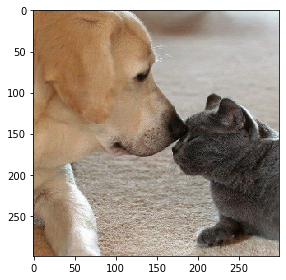

In [ ]:
Xi = skimage.io.imread("https://arteagac.github.io/blog/lime_image/img/cat-and-dog.jpg")
Xi = skimage.transform.resize(Xi, (299,299)) 
Xi = (Xi - 0.5)*2 #Inception pre-processing
skimage.io.imshow(Xi/2+0.5) # Show image before inception preprocessing

### Predict class of input image
The Inception V3 model is used to predict the class of the image. The output of the classification is a vector of 1000 proabilities of beloging to each class available in Inception V3. The description of these classes is shown and it can be seen that the "Labrador Retriever" is the top class for the given image.

In [ ]:
np.random.seed(222)
preds = inceptionV3_model.predict(Xi[np.newaxis,:,:,:])
decode_predictions(preds)[0] #Top 5 classes


40960/35363 [==================================] - 0s 0us/step


[('n02099712', 'Labrador_retriever', 0.8273345),
 ('n02099601', 'golden_retriever', 0.014789644),
 ('n02093428', 'American_Staffordshire_terrier', 0.008711368),
 ('n02108422', 'bull_mastiff', 0.008177893),
 ('n02109047', 'Great_Dane', 0.007899417)]

The indexes (positions) of the top 5 classes are saved in the variable `top_pred_classes`

In [ ]:
top_pred_classes = preds[0].argsort()[-5:][::-1]
top_pred_classes                #Index of top 5 classes

array([208, 207, 180, 243, 246])

## LIME explanations
The following figure illustrates the basic idea behind LIME. The figure shows light and dark gray areas which are the decision boundaries for the classes for each (x1,x2) pairs in the dataset. LIME is able to provide explanations for the predictions of an individual record (blue dot). The  explanations are created by generating a new dataset of perturbations around the instance to be explained (colored markers around the blue dot). The output or class of each generated perturbation is predicted with the machine-learning model (colored markers inside and outside the decision boundaries). The importance of each perturbation is determined by measuring its distance from the original instance to be explained. These distances are converted to weights by mapping the distances to a zero-one scale using a kernel function (see color scale for the weights). All this information: the new generated dataset, its class predictions and its weights are used to fit a simpler model, such as a linear model (blue line), that can be interpreted. The attributes of the simpler model, coefficients for the case of a linear model, are then used to generate explanations.  
![alt text](https://arteagac.github.io/blog/lime_image/img/lime_illustration.png)

A detailed explanation of each step is shown below.

### Step 1: Create perturbations of image
For the case of image explanations, perturbations will be generated by turning on and off some of the superpixels in the image.

#### Extract super-pixels from image
Superpixels are generated using the quickshift segmentation algorithm. It can be noted that for the given image, 68 superpixels were generated. The generated superpixels are shown in the image below.

In [ ]:
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

68

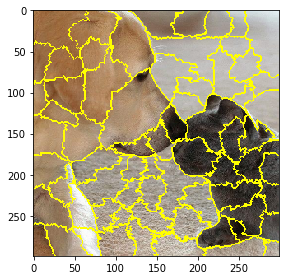

In [ ]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))

#### Create random perturbations
In this example, 150 perturbations were used. However, for real life applications, a larger number of perturbations will produce more reliable explanations. Random zeros and ones are generated and shaped as a matrix with perturbations as rows and superpixels as columns. An example of a perturbation (the first one) is show below. Here, `1` represent that a superpixel is on and `0` represents it is off. Notice that the length of the shown vector corresponds to the number of superpixels in the image.

In [ ]:
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0])

The following function `perturb_image` perturbs the given image (`img`) based on a perturbation vector (`perturbation`) and predefined superpixels (`segments`).

In [ ]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

Let's use the previous function to see what a perturbed image would look like:

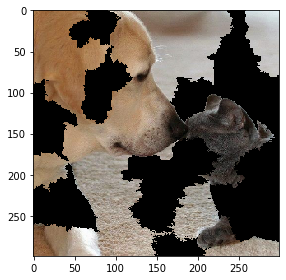

In [ ]:
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))

### Step 2: Use ML classifier to predict classes of new generated images
This is the most computationally expensive step in LIME because a prediction for each perturbed image is computed. From the shape of the predictions we can see for each of the perturbations we have the output probability for each of the 1000 classes in Inception V3. 

In [ ]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

(150, 1, 1000)

### Step 3: Compute distances between the original image and each of the perturbed images and compute weights (importance) of each perturbed image
The distance between each randomly generated perturnation and the image being explained is computed using the cosine distance. For the shape of the `distances` array it can be noted that, as expected, there is a distance for every generated perturbation.

In [ ]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(150,)

#### Use kernel function to compute weights
The distances are then mapped to a value between zero and one (weight) using a kernel function. An example of a kernel function with different kernel widths is shown in the plot below. Here the x axis represents distances and the y axis the weights. Depeding on how we set the kernel width, it defines how wide we want the "locality" around our instance to be. This kernel width can be set based on expected distance values. For the case of cosine distances, we expect them to be somehow stable (between 0 and 1); therefore, no fine tunning of the kernel width might be required.

<img src="https://arteagac.github.io/blog/lime_image/img/kernel.png" alt="Drawing" width="600"/>

In [ ]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(150,)

### Step 4: Use `perturbations`, `predictions` and `weights` to fit an explainable (linear) model
A weighed linear regression model is fitted using data from the previous steps (perturbations, predictions and weights). Given that the class that we want to explain is labrador, when fitting the linear model we take from the predictions vector only the column corresponding to the top predicted class. Each coefficients in the linear model corresponds to one superpixel in the segmented image. These coefficients represent how important is each superpixel for the prediction of labrador.

In [ ]:
class_to_explain = top_pred_classes[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([ 0.0199833 , -0.01601374,  0.10354327, -0.04821644,  0.08925877,
        0.07826848,  0.02714029,  0.07659395,  0.18122355, -0.05638588,
        0.03509676,  0.00470357,  0.02208912,  0.10356663,  0.07223697,
        0.0034734 ,  0.08162887,  0.03907232,  0.00769051,  0.02527205,
       -0.0100494 ,  0.02130284, -0.07029254, -0.02555164,  0.52121138,
        0.0205534 ,  0.0013183 , -0.17025011, -0.03082538,  0.14881233,
        0.05691062,  0.1011255 , -0.01224566, -0.04081408, -0.03864275,
       -0.02153394, -0.05745923,  0.02746975,  0.03796638,  0.03152467,
        0.03358099,  0.00733296,  0.04806797, -0.02303122, -0.0145786 ,
        0.08431814,  0.008036  , -0.01945883, -0.09000518,  0.05641921,
        0.02874261,  0.01926118, -0.03653446,  0.03901715, -0.05825456,
        0.03474161, -0.102688  ,  0.00780907, -0.03470868,  0.03349195,
        0.06900843, -0.05142001,  0.02219387,  0.05436448,  0.01072274,
       -0.03208548,  0.09252425, -0.0057378 ])

#### Compute top features (superpixels)
Now we just need to sort the coefficients to figure out which are the supperpixels that have larger coefficients (magnitude) for the prediction of labradors. The identifiers of these top features or superpixels are shown below. Even though here we use the magnitude of the coefficients to determine the most important features, other alternatives such as forward or backward elimination can be used for feature importance selection. 

In [ ]:
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([13, 29,  8, 24])

#### Show LIME explanation (image with top features)
Let's show the most important superpixels defined in the previous step in an image after covering up less relevant superpixels.

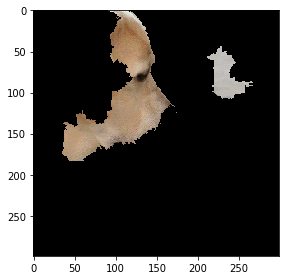

In [ ]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )

This is the final step where we obtain the area of the image that produced the prediction of labrador. You can download this notebook and perhaps test your own images to obtain explanations for your classification tasks. Also, you can use link at the beggining of the notebook to open and test it in the Google Colab environment without having to install anything in your computer.